In [12]:
#!/usr/bin/env python3
"""James Gardner 2019

scores each pair in the catalogue,
adds scores to feature vectors
"""

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

SEPARATION_LIMIT = 5*1/60

In [13]:
catalogue = pd.read_csv('patch_catalogue.csv')
catalogue.set_index(['name_TGSS','name_NVSS'], inplace=True)
# catalogue = catalogue.set_index(['name_TGSS','name_NVSS'],inplace=True)

cat_matches = set(catalogue.index.values)

In [14]:
tgss_df = pd.read_csv('tgss.csv')
tgss_df.set_index('name_TGSS', inplace=True)

nvss_df = pd.read_csv('nvss.csv')
nvss_df.set_index('name_NVSS', inplace=True)

In [15]:
def naivest_scorer(name_TGSS,name_NVSS):
    """given two names, tells if in catalogue"""  
    if (name_TGSS,name_NVSS) in catalogue.index:
        return 1
    else:
        return 0

In [16]:
def separation_scorer(name_TGSS,name_NVSS):
    """given two names, gives separation
    by set-up, only gives non-zero for those in catalogue"""
    if (name_TGSS,name_NVSS) in catalogue.index:
        sep = catalogue.loc[name_TGSS,name_NVSS].separation
        sep *= 3600
        return max(0,(5*60-sep)/(5*60))
    else:
        return 0

In [17]:
def spectral_scorer(name_TGSS,name_NVSS):
    """given two names, not necessarially in catalogue
    returns score using hist_alpha dist as pdf
    takes two arbitrary names, looks them up in respective
    catalogues, and runs the scorer on them"""

    alpha = catalogue['spectral_alpha'].values
    num_alpha_bins = 100
    pdf_alpha = np.histogram(alpha,bins=num_alpha_bins,density=True)
    a0,a1 = np.min(alpha),np.max(alpha)    
    
    obj_t = tgss_df.loc[name_TGSS]
    obj_n = nvss_df.loc[name_NVSS]
    
    FREQ_TGSS,FREQ_NVSS = 150e6,1.4e9
    my_alpha = np.log(obj_t['peak_TGSS']/obj_n['peak_NVSS']
                     )/np.log(FREQ_NVSS/FREQ_TGSS)

    if my_alpha < a0 or a1 < my_alpha:
        return 0
    else:
        #re-normalise
        pval = pdf_alpha[0][min(np.searchsorted(pdf_alpha[1],my_alpha),
                                len(pdf_alpha[0])-1)]
        pval = pval/(a1-a0)
        return pval

In [18]:
def combo_scorer(name_TGSS,name_NVSS):
    """weighted score from sep and alpha pdf
    non-naive scorer uses separation and spectral index
    """
    s1 = separation_scorer(name_TGSS,name_NVSS)
    s2 = spectral_scorer(name_TGSS,name_NVSS)
    # change w1 to rebalance
    w1 = 0.8
    w2 = 1-w1
    return w1*s1+w2*s2

In [21]:
scores = [separation_scorer(name_TGSS,name_NVSS)
          for (name_TGSS,name_NVSS) in tqdm(catalogue.index.values)]
catalogue['score'] = scores
catalogue.sort_values(by=['score'],inplace=True)
catalogue.to_csv('patch_catalogue.csv')

In [8]:
def score_the_cat(catalogue,scorer,hist_name=None):
    """evaluates the scorer on each match in the catalogue,
    saves a histogram of the scores
    """
    stc = np.array([scorer(name_TGSS,name_NVSS) for 
                    (name_TGSS,name_NVSS) in tqdm(cat_matches)])
    stc = stc[stc!=0]
    
    # normalise, top score is now 1
    top = np.max(stc)
    stc = stc*1/top    
    
    if hist_name is None:
        hist_name = 'hist_patch_cat_score'
        
    # display histogram of scores
    plt.figure(figsize=(14,7))
    plt.rcParams.update({'font.size': 18})
    plt.hist(stc, bins=100)#,color = "darkmagenta", ec="orchid")
    plt.xlim(-0.01,1.01)
    plt.xlabel("match score")
    plt.ylabel('counts')
    plt.title('distribution of scores of catalogue matches in patch')
    plt.savefig('{}.pdf'.format(hist_name),bbox_inches='tight')    

KeyboardInterrupt: 

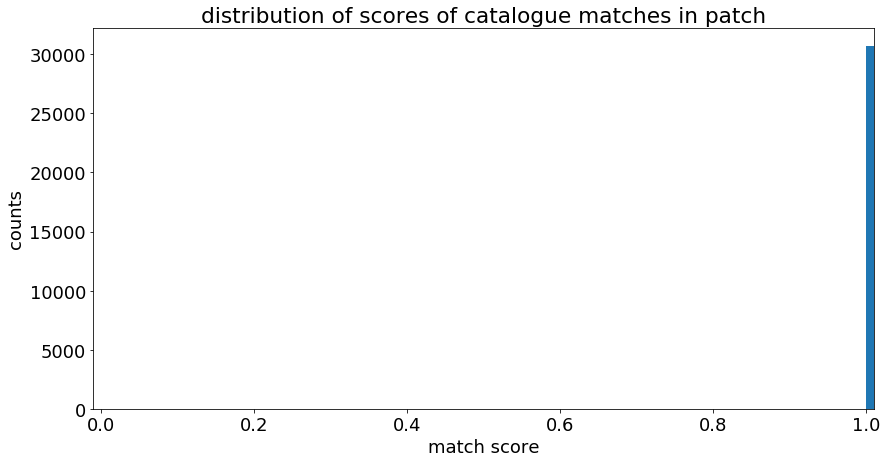

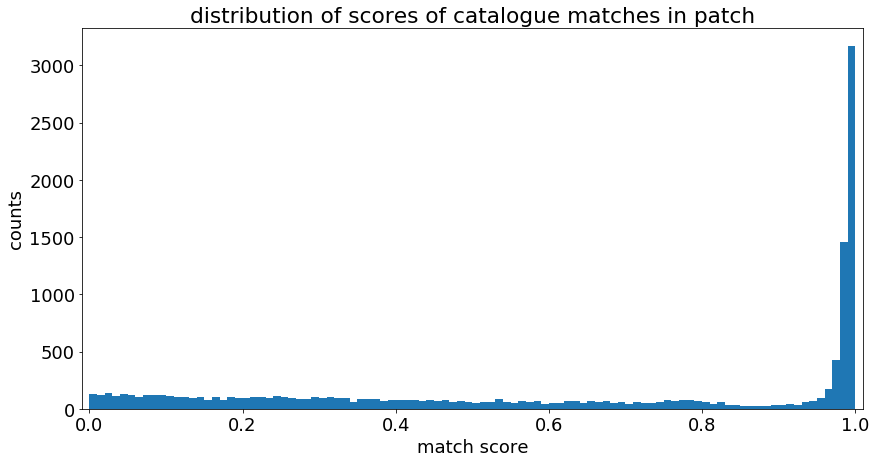

In [9]:
hist_names = {'hist_patch_cat_score_naive':naivest_scorer,
              'hist_patch_cat_score_separation':separation_scorer,
              'hist_patch_cat_score_spectral':spectral_scorer,
              'hist_patch_cat_score_combo':combo_scorer}

for key in hist_names:
    score_the_cat(catalogue,hist_names[key],key)

In [10]:
# always called within a reset_index environment for tgss,nvss and NOT cat
SEPARATION_LIMIT = 10*1/60

def looper_TGSS_scorer(name_TGSS,scorer):
    obj_t = tgss_df.loc[tgss_df['name_TGSS'] == name_TGSS]
    t_dec = obj_t['dec_TGSS'].values[0]
    nvss_nearby_df = nvss_df[(t_dec-SEPARATION_LIMIT < nvss_df['dec_NVSS']) &
                             (nvss_df['dec_NVSS'] < t_dec+SEPARATION_LIMIT)]
    best_match = (0,'')
    for name_NVSS in nvss_nearby_df.index.values:
        score = scorer(name_TGSS,name_NVSS)
        if best_match[0] < score:
            best_match = (score,name_NVSS)
    return best_match

def looper_NVSS_scorer(name_NVSS,scorer):
    obj_n = nvss_df.loc[nvss_df['name_NVSS'] == name_NVSS]
    n_dec = obj_n['dec_NVSS'].values[0]
    tgss_nearby_df = tgss_df[(n_dec-SEPARATION_LIMIT < tgss_df['dec_TGSS']) &
                             (tgss_df['dec_TGSS'] < n_dec+SEPARATION_LIMIT)]    
    best_match = (0,'')
    for name_TGSS in tgss_nearby_df.index.values:
        score = scorer(name_TGSS,name_NVSS)
        if best_match[0] < score:
            best_match = (score,name_TGSS)
    return best_match

In [11]:
# sort the sky
scorer_to_use = separation_scorer

tgss_df.reset_index(inplace=True)
best_match = np.array([looper_TGSS_scorer(name_TGSS,scorer_to_use)
                       for name_TGSS in tqdm(tgss_df['name_TGSS'])])
tgss_df['score'] = best_match[:,0]
tgss_df['best_match'] = best_match[:,1]
tgss_df.set_index('name_TGSS',inplace=True)
tgss_df.sort_values(by=['score'],inplace=True)
tgss_df.to_csv('tgss.csv')

nvss_df.reset_index(inplace=True)
best_match = np.array([looper_NVSS_scorer(name_NVSS,scorer_to_use)
                       for name_NVSS in tqdm(nvss_df['name_NVSS'])])
nvss_df['score'] = best_match[:,0]
nvss_df['best_match'] = best_match[:,1]
nvss_df.set_index('name_NVSS',inplace=True)
nvss_df.sort_values(by=['score'],inplace=True)
nvss_df.to_csv('nvss.csv')

KeyboardInterrupt: 